<a href="https://colab.research.google.com/github/bricap/rmp-Project-Repository/blob/main/Facial_Recognition_PCA_NMF_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Principal Component Analysis and Non-Negative Matrix Factorization


Dimensionality reduction with Principle Component Analysis (PCA) and Non-negative Matrix Factorization (NMF).

The two techniques differ in the constraints they impose on the dictionary elements and the representations, which in-turn leads to a completely different objective function and the optimization algorithm.

**Discussion**
1. Why might we want to reduce the dimensionality of a dataset?

2. Can you explain PCA and NMF? What are the differences?


1. In order to relatively compare the features to each other, centered around the origin, on the same scale. You do this by subtracting the mean and divding by the SD.
2. PCA allows negative values; NMF doesn’t. PCA finds global directions; NMF finds parts. PCA uses orthogonal components; NMF does not.

## Principal Component Analysis (PCA)

PCA is essentially a projection method, which involves computing the projections of the original input into a smaller dimension representation such that the error between the original vector and the reconstructed is minimized.


$$
\arg \min_{W,Z} \| X - WZ \|^2_F
$$


This method is mathematically equivalent to maximizing the variance of the projected data and can be efficiently computed by decomposing the data matrix $X$ into its singular values.

**Discussion**
1. Why does maximizing variance lead to a good low-dimensional representation?

Variance is information content, maximizing it gives you more info of the data than if everything is the same. Explaining more of the data with lower dimensions.

### Load the dataset

We will first load the standard packages and then load and use the black-white faces data set, which is available to download from here:
https://github.com/HyTruongSon/Pattern-Classification/tree/master/MIT-CBCL-database

We have the files already in the folder distributed in the link: https://drive.google.com/drive/folders/1giVtcN6X03O26Q3j7zUMqjuAc5FR1cAI?usp=share_link

Load the standard packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy import linalg
from scipy.sparse import diags
import scipy.optimize

import autograd
from autograd import grad
import autograd.numpy as numpy
import autograd.numpy.random as npr

%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/MyDrive/Fundamentals of Machine Learning/Lab12')

# the normalize function which first computes the mean
# and then subtracts it from all the data points
def normalize(data):
    mean = np.mean(data, axis=1)[:,None]
    return data - mean

Mounted at /content/gdrive/


Load the dataset and display a test image

Input data shape: (2429, 361)


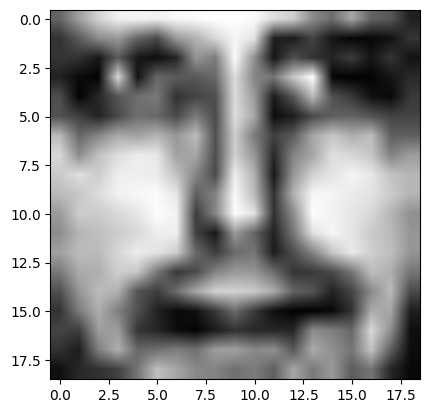

In [5]:
raw_data = open('/content/gdrive/MyDrive/Fundamentals of Machine Learning/Lab12/data/svm.train.normgrey').readlines()
X = []

for line in raw_data[2:]:
    if line.strip() == "":
        continue
    if int(line.split()[-1]) == -1:
        # not face, skip
        continue
    else:
        X.append( [float(yy) for yy in line.split()[:-1]] )

X = np.array(X)
print('Input data shape: {}'.format(X.shape))

plt.imshow(X[0].reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")

X = normalize(X)
X = np.transpose(X)

**Discussion**
1. Why do we normalize the data before applying PCA?
2. Why do we take the transpose of the data before applying PCA?

1. In order to make it comparable, to account for the differences in units acorss features. All on one scale.
2. How to derive the principle components, need to compute dot porduxct of each feature with one another. PCA calculates the xovarince between features. Wanr to have feature-feature covariance, so noeed to make sure aata in teh right shape to compute the covariance in the right way.



Get the size of the original input space and also set the size of the new low-dimensional output space

In [6]:
n_comp = 121  # how many dimensions will be in the new space

(d, N) = X.shape
q = n_comp

print ("d: ",  d)
print ("N: ", N)
print ("q: ", q)

d:  361
N:  2429
q:  121


**Discussion**
1. What does the shape of does the shape of
X tell us? What is d? What is N? What is q?
2. What might PCA mistakenly capture if we skip normalization?

1. X=matrix, d=number of dimensions, n=number of samples, q=number of retained principle components
2. Biased towards feature of higher values because not scaled down, the model would mistakenly value higher values with more power than it actually has.

### Compute the Principal Components

We use the Singular Value Decomposition of the matrix X to compute all the components.

In [7]:
def train_pca_svd(input_data):
    U, S, V = linalg.svd(X)  # SVD decomposition
    print('Input dimensions: {}'.format(input_data.shape))
    print('Left singular vector matrix shape: {}'.format(U.shape))
    print('Right singular vector matrix shape: {}'.format(V.shape))
    print('Singular value matrix shape: {}'.format(S.shape))

    return S, U

In [8]:
S_faces, U_faces = train_pca_svd(X)

Input dimensions: (361, 2429)
Left singular vector matrix shape: (361, 361)
Right singular vector matrix shape: (2429, 2429)
Singular value matrix shape: (361,)


In order to compute the principal components, we take the most impactful columns of the left singular matrix

In [9]:
# take q most impactful columns from U. These are your principal components
top_vectors = U_faces[:, :q]

# reduce dimensionality of our input data by projecting each point onto the principal components
X_reduced = X.transpose() @ top_vectors

In [10]:
# lets check the shape of the old and the new data matrix
np.transpose(X).shape, X_reduced.shape

((2429, 361), (2429, 121))

**Discussion**


1.   Why use SVD to compute PCA?
2.   What do U, S, and V represent? You can check the documentation of linalg.svd to answer.
3.   Why use the left singular vectors U?
4. Why would directions with larger singular values matter more?
5. Why does keeping only the top directions reduce noise?



1. More numerically stable to get the eigenvectors, SVD gives you bases vectors
Want to reduce reconstruction error
2. U=left singular vectors(eigenvalues), V=right singular vectors(principle directions), S=singular value matrix shape (strength of the directions)
3. Becuase they are the eigenvalues so they tell us how important (the magnitude) of the features
4. Because that means they have higher meaning bc higher eigenvalues. The bigger the value, the more variance is explained
5. Becuase ruling out lower eigenvalues and only keeping the highest values will remove the noise.

### Visualization of principle components

We now project each face onto the principal components and reconstruct it.

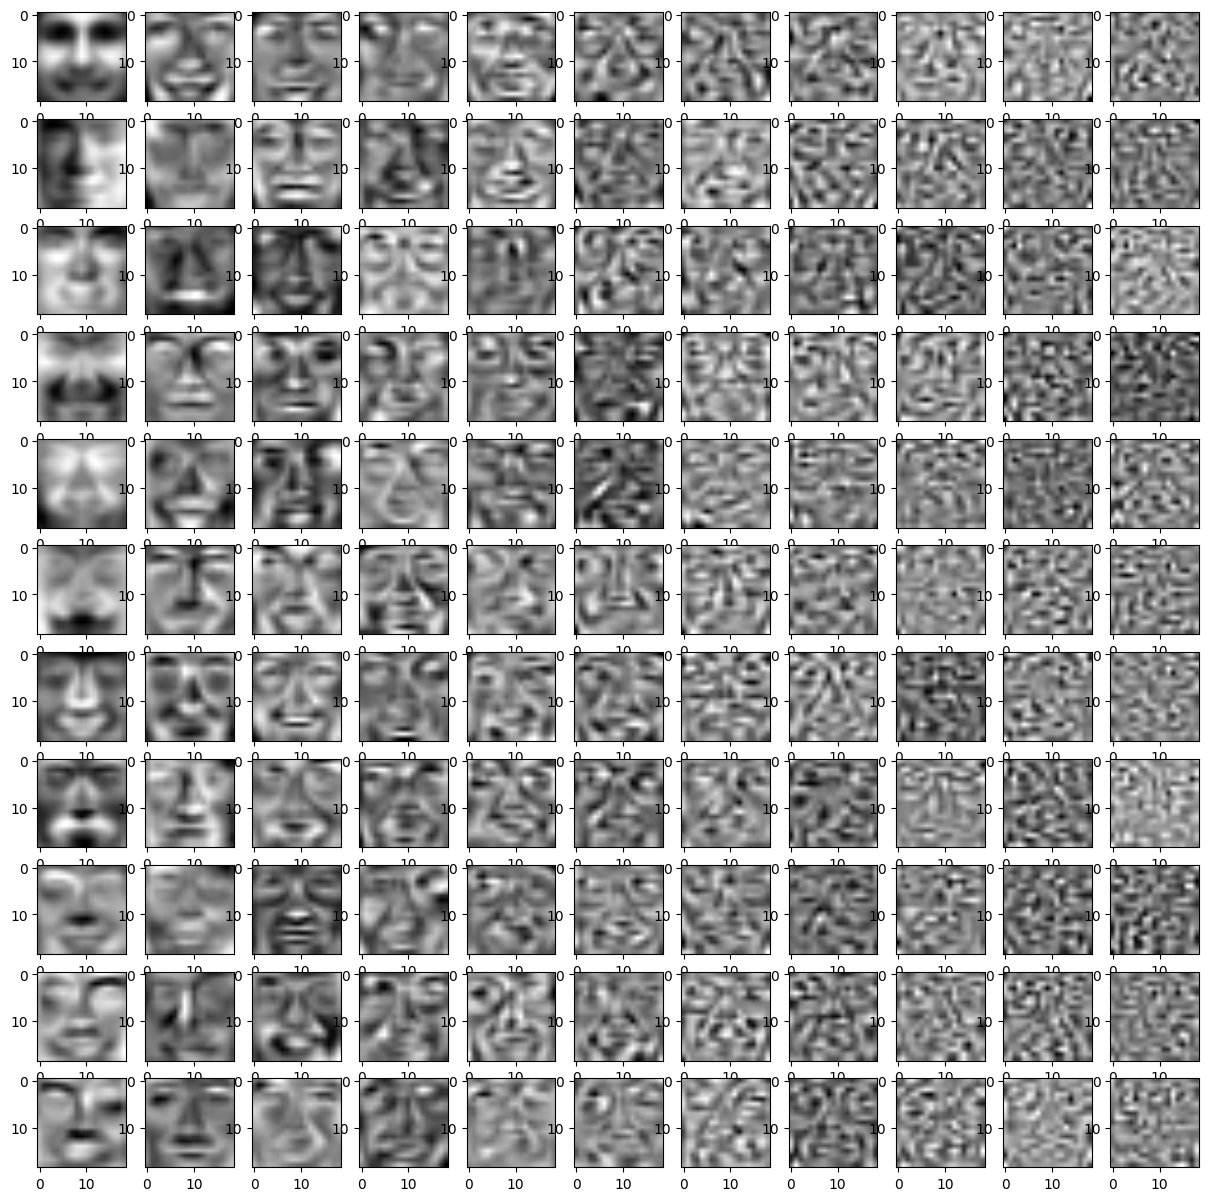

In [11]:
loadings = top_vectors.transpose()
f, axarr = plt.subplots(int(np.sqrt(n_comp)), int(np.sqrt(n_comp)), figsize = (15, 15))

comp_ix = 0
# loop over the principal components and display them as an image of size 19x19
for j in range(int(np.sqrt(n_comp))):
    for i in range(int(np.sqrt(n_comp))):
        axarr[i, j].imshow(loadings[comp_ix].reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")
        comp_ix += 1

In [12]:
# compute the reconstruction error between the original and reconstructed image
reconstruction_err = np.linalg.norm( X - top_vectors @ np.transpose(X_reduced) )
print ('Reconstructions error: ', reconstruction_err)

Reconstructions error:  38.38769195134055


# Reconstruct the image back from the reduced space

In [13]:
def reconstruct_face(idx):
    original_face = X[:,idx]
    reduced_face = X_reduced[idx]
    reconstructed_face = reduced_face @ loadings

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(original_face.reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")

    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed_face.reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")

In [14]:
loadings.shape

(121, 361)

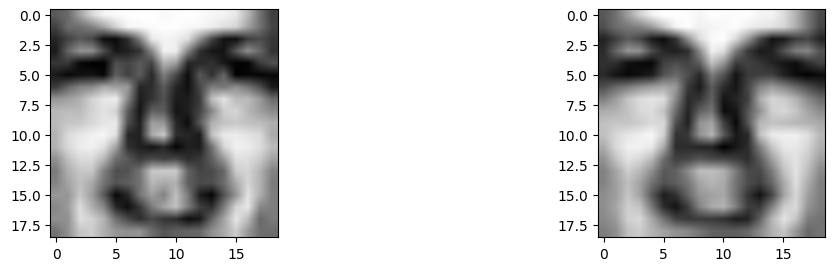

In [15]:
# the reconstructed face does not look that bad
reconstruct_face(20)

**Discussion**
1. When reconstructing, why does adding more components improve the image?
2. Why do PCA components look like ghost faces instead of real faces?

1. Adding more components imporves the image becuase you are adding more information, so the image gets closer to the original
2. Becuase they only use the key features to construct the face at lower dimensions

## Non-Negative Matrix Factorization (NMF)
The optimization problem for non-negative matrix factorization is similar to the PCA, except it has additional non-negativity constraints on $W$ and $Z$.

$$
\begin{align}
\arg \min_{W,Z} & \| X - WZ \|^2_F \\
s.t. \quad & w_{ij} \ge 0 \quad i = 1, \ldots, n \quad j = 1, \ldots, p \\
           & z_{ij} \ge 0 \quad i = 1, \ldots, p \quad j = 1, \ldots, n \\
\end{align}
$$

Presence of additional constraints makes the optimization problem a little harder.

**Discussion**
1. Given that NMF is only non-negative (additive), can you think of an intuitive way to explain it?
2. So when would NMF be appropriate to use?  

1. NMF builds things by adding small positive “parts” together, like building a face from eyes + nose + mouth, or building a song from different instrument tracks. Because it never subtracts, each part always adds something meaningful, making the pieces easy to interpret.
2. Use NMF when the data is naturally non-negative and you want interpretable, parts-based components, like images or music (where the data is made of positive pieces).

In [16]:
def train_nmf(input_data):
    multiplicative = True
    maxiter = 1000
    X = input_data
    W = np.real( (np.random.rand(d,q))*0.5 )
    Z = np.real( (np.random.rand(q,N))*0.5 )
    print ('start optimising...')
    # X : (d, N)
    # W : (d, q)
    # Z : (q, N)
    for u_iter in range(maxiter):
        if multiplicative:
            diff = X - W @ Z
            W = W * (X @ np.transpose(Z)) / (W @ Z @ np.transpose(Z))
            Z = Z * (np.transpose(W) @ X) / (np.transpose(W) @ W @ Z)
        else:
            diff = X - W @ Z
            lr = 0.001
            W_ = W + lr * (diff) @ np.transpose(Z)
            Z_ = Z + lr * np.transpose(W) @ (diff)
            W, Z = np.maximum(W_, 0, W_), np.maximum(Z_, 0, Z_)

        if u_iter % 100 == 0:
            print (autograd.numpy.linalg.norm(diff))

    print ('optimization finished')
    return W, Z

In [17]:
X = X - np.min(X)  # why do we do that?

loadings, X_reduced = train_nmf(X)

start optimising...
6620.831749778946
87.58963796362738
70.80719518681823
65.21457970872338
62.319284114805754
60.50368139479293
59.23342348727794
58.283454171373656
57.53985696941736
56.939180836001746
optimization finished


In [18]:
loadings = loadings.transpose()

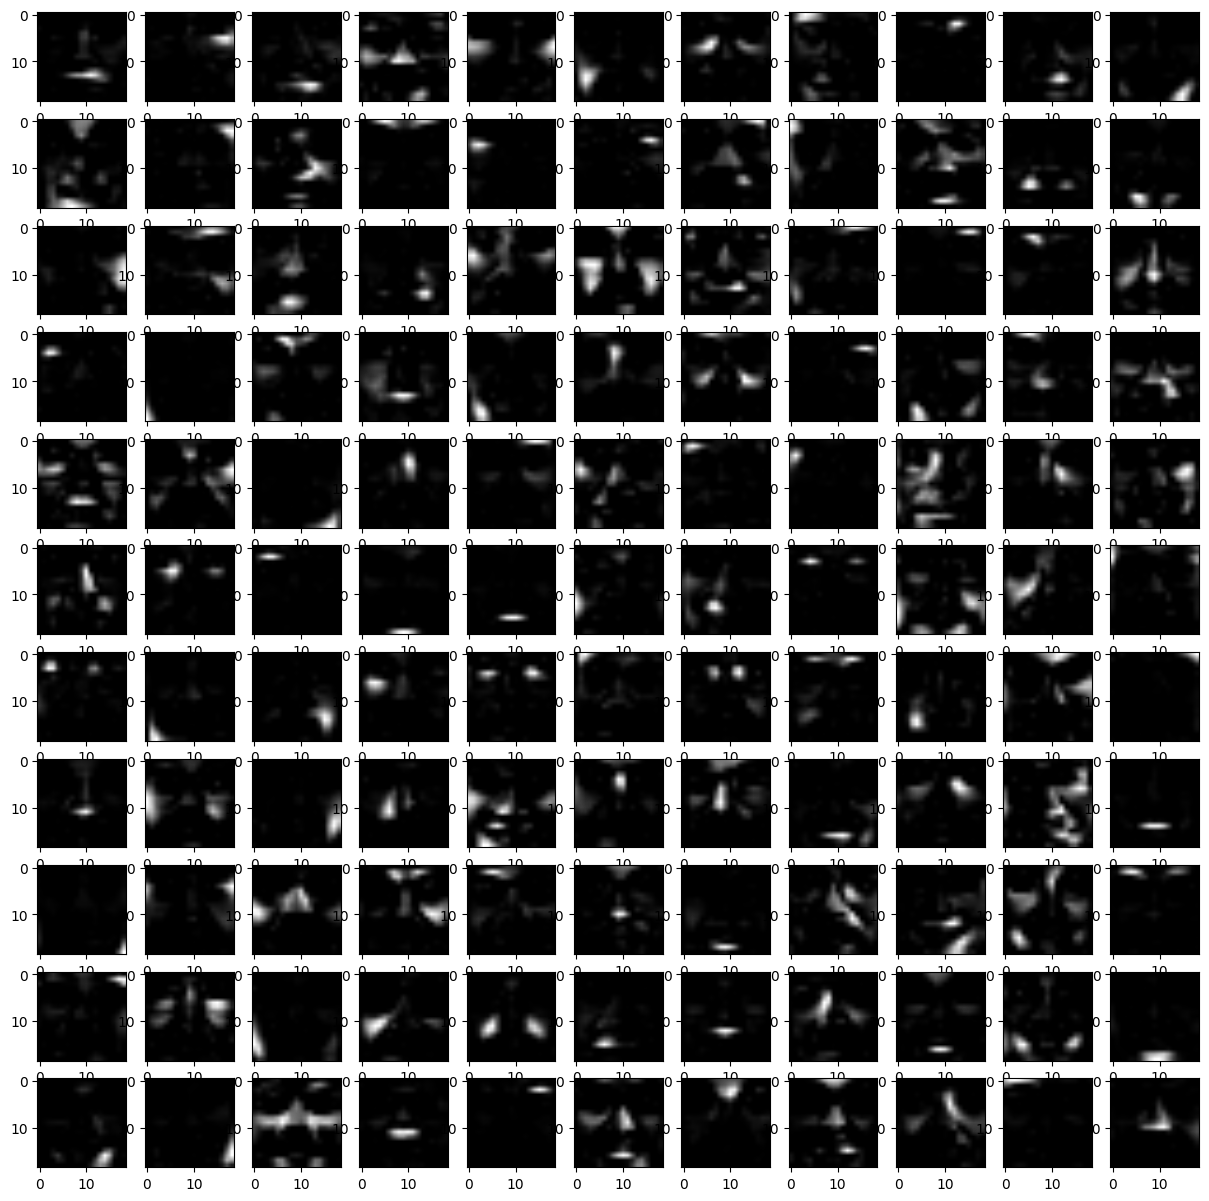

In [19]:
# visualize the factorization learnt
f, axarr = plt.subplots(int(np.sqrt(n_comp)), int(np.sqrt(n_comp)), figsize = (15, 15))

comp_ix = 0
for j in range(int(np.sqrt(n_comp))):
    for i in range(int(np.sqrt(n_comp))):
        axarr[i, j].imshow(loadings[comp_ix].reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")
        comp_ix += 1

**Discussion**
1. Which facial regions appear consistently as components?
2. Why might NMF be more interpretable than PCA for faces?
3.How would you describe each NMF component in plain language?
4. When would you prefer PCA over NMF?

Facial regions that appear consistently are things like eyes, nose, mouth, cheeks, and shadows—distinct parts of the face.

NMF is more interpretable than PCA for faces because it builds faces by adding meaningful parts rather than mixing positive and negative patterns.

Each NMF component can be described as a single facial feature or region (e.g., “left eye,” “mouth area").

PCA is preferred over NMF when you want maximum variance explained and faster computation.

## Featurizing text data and reducing its dimensionality

We will now see a second example of dimensionality reduction on text data. In this data set, each document will be a training sample and it will be represented as a tf-idf vector. Tf-idf which is an abbreviation of **Term Frequency Inverse Document Frequency** and its definition is provided here: https://en.wikipedia.org/wiki/Tf%E2%80%93idf  

In [20]:
from sklearn import datasets
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

newsgroups_train= datasets.fetch_20newsgroups(subset='train',
                                               categories=['comp.sys.mac.hardware', 'rec.motorcycles', 'sci.med', 'soc.religion.christian'])
tfidf_vectorizer = TfidfVectorizer(min_df=30)
X = tfidf_vectorizer.fit_transform(newsgroups_train.data).toarray()
y = newsgroups_train.target

In [21]:
print(X[0][0:100])
print(y)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.06961504 0.         0.
 0.         0.         0.         0.         0.07296304 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.0963884  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[2 2 0 ...

In [22]:
X = np.transpose(X)

(d, N) = X.shape
q = 5  # our reduced dimension

print ("d: old dim",  d)
print ("N: num of samples", N)
print ("q: new dim", q)

d: old dim 1771
N: num of samples 2369
q: new dim 5


In [23]:
S_text, V_text = train_pca_svd(X)

Input dimensions: (1771, 2369)
Left singular vector matrix shape: (1771, 1771)
Right singular vector matrix shape: (2369, 2369)
Singular value matrix shape: (1771,)


In [24]:
# take q most impactful columns from V
top_vectors = V_text[:, :q]

# reduce dimensionality of our input data
X_reduced = X.transpose() @ top_vectors

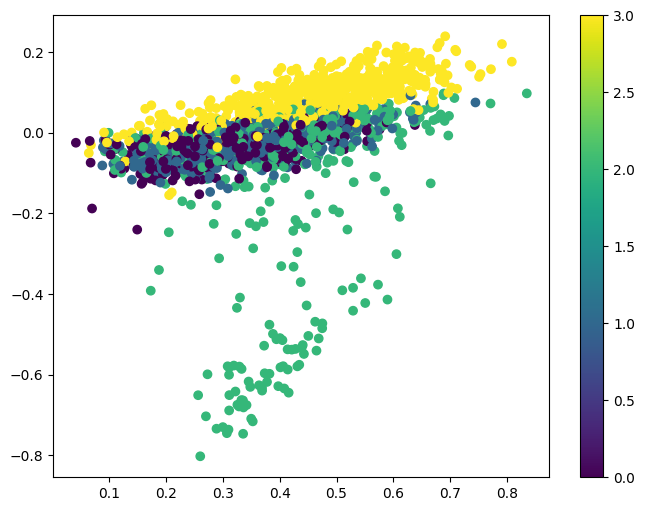

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:,0], X_reduced[:, 1], c = y)
plt.colorbar()

In [26]:
loadings = top_vectors.transpose()
invocab = dict([(vv,kk) for kk, vv in tfidf_vectorizer.vocabulary_.items()])
insens_idx = np.argsort(loadings[0])

print ('Top 10 most activated words (loadings)')
for jj in insens_idx[-10:]:
    print ('{} ({:0.6f})'.format(invocab[jj], loadings[0,jj]))


print ('\n Top 10 least activated words (loadings)')
for jj in insens_idx[:10]:
    print ('{} ({:0.6f})'.format(invocab[jj], loadings[0,jj]))

Top 10 most activated words (loadings)
for (0.114492)
you (0.132383)
it (0.160184)
that (0.178339)
in (0.184909)
is (0.189900)
and (0.206761)
of (0.255349)
to (0.266096)
the (0.472707)

 Top 10 least activated words (loadings)
58 (0.002314)
reduce (0.002355)
mon (0.002376)
despite (0.002425)
toward (0.002450)
51 (0.002455)
developed (0.002462)
argue (0.002472)
typical (0.002473)
1st (0.002503)


In [27]:
reconstruction_err = np.linalg.norm( X - top_vectors @ np.transpose(X_reduced) )
print ('Reconstructions error: ', reconstruction_err)

Reconstructions error:  43.35201754483636


## Prepare for PCA analysis


Define the target dimensions (200, 100, 50) and initialize lists to store reconstruction errors and reconstructed images for each dimension.


**Reasoning**:
I will define the `target_dimensions` list and initialize `reconstruction_errors` and `reconstructed_images_samples` as empty lists, as per the instructions, in a code cell.



In [28]:
target_dimensions = [200, 100, 50]
reconstruction_errors = []
reconstructed_images_samples = []

print("Target dimensions defined.")

Target dimensions defined.


## Perform PCA and Reconstruction Loop


Iterate through each target dimension, perform PCA using SVD, reduce the dimensionality of the data, reconstruct the data back to the original space, and calculate the reconstruction error. Store the error and a sample reconstructed image for later plotting.


**Reasoning**:
I will iterate through the defined target dimensions, performing PCA, reducing dimensionality, reconstructing data, calculating reconstruction errors, and storing a sample reconstructed image for each dimension as instructed.



In [29]:
sample_face_idx = 20 # Fixed index for the sample face

for q in target_dimensions:
    # 3. For each q, select the top q principal components
    current_top_vectors = U_faces[:, :q]

    # 4. Reduce the dimensionality of the original data X
    X_reduced_dim = X.transpose() @ current_top_vectors

    # 5. Reconstruct the data back to the original dimension
    X_reconstructed = current_top_vectors @ X_reduced_dim.transpose()

    # 6. Calculate the reconstruction error using the Frobenius norm
    reconstruction_err = np.linalg.norm(X - X_reconstructed)
    reconstruction_errors.append(reconstruction_err)

    # 7. Reconstruct the sample face
    original_sample_face = X[:, sample_face_idx]
    reduced_sample_face = X_reduced_dim[sample_face_idx]
    reconstructed_sample_face = reduced_sample_face @ current_top_vectors.transpose()
    reconstructed_images_samples.append(reconstructed_sample_face)

print("PCA analysis for different dimensions completed.")
print(f"Reconstruction errors: {reconstruction_errors}")

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 361 is different from 1771)

**Reasoning**:
The previous code failed because the global variable `X` was overwritten with text data, while `U_faces` (principal components) was derived from face data. This led to a dimension mismatch during matrix multiplication. I need to re-initialize `X` with the correct facial image data (normalized and transposed) and use it in the PCA and reconstruction loop to ensure consistency with `U_faces`.



In [30]:
raw_data_faces = open('/content/gdrive/MyDrive/Fundamentals of Machine Learning/Lab12/data/svm.train.normgrey').readlines()
X_faces_data = []

for line in raw_data_faces[2:]:
    if line.strip() == "":
        continue
    if int(line.split()[-1]) == -1:
        continue
    else:
        X_faces_data.append( [float(yy) for yy in line.split()[:-1]] )

X_faces_data = np.array(X_faces_data)
X_faces_data = normalize(X_faces_data)
X_faces_data = np.transpose(X_faces_data)

sample_face_idx = 20 # Fixed index for the sample face

for q in target_dimensions:
    # 3. For each q, select the top q principal components
    current_top_vectors = U_faces[:, :q]

    # 4. Reduce the dimensionality of the original data X_faces_data
    X_reduced_dim = X_faces_data.transpose() @ current_top_vectors

    # 5. Reconstruct the data back to the original dimension
    X_reconstructed = current_top_vectors @ X_reduced_dim.transpose()

    # 6. Calculate the reconstruction error using the Frobenius norm
    reconstruction_err = np.linalg.norm(X_faces_data - X_reconstructed)
    reconstruction_errors.append(reconstruction_err)

    # 7. Reconstruct the sample face
    original_sample_face = X_faces_data[:, sample_face_idx]
    reduced_sample_face = X_reduced_dim[sample_face_idx]
    reconstructed_sample_face = reduced_sample_face @ current_top_vectors.transpose()
    reconstructed_images_samples.append(reconstructed_sample_face)

print("PCA analysis for different dimensions completed.")
print(f"Reconstruction errors: {reconstruction_errors}")

PCA analysis for different dimensions completed.
Reconstruction errors: [np.float64(21.714973987584358), np.float64(44.95124307932051), np.float64(70.2135874085596)]


**Reasoning**:
The PCA analysis and data reconstruction for different dimensions have been successfully performed. Now, I need to generate a visual comparison of the reconstructed images for each target dimension as requested in the task. This involves creating a single plot with subplots for each reconstructed sample face.



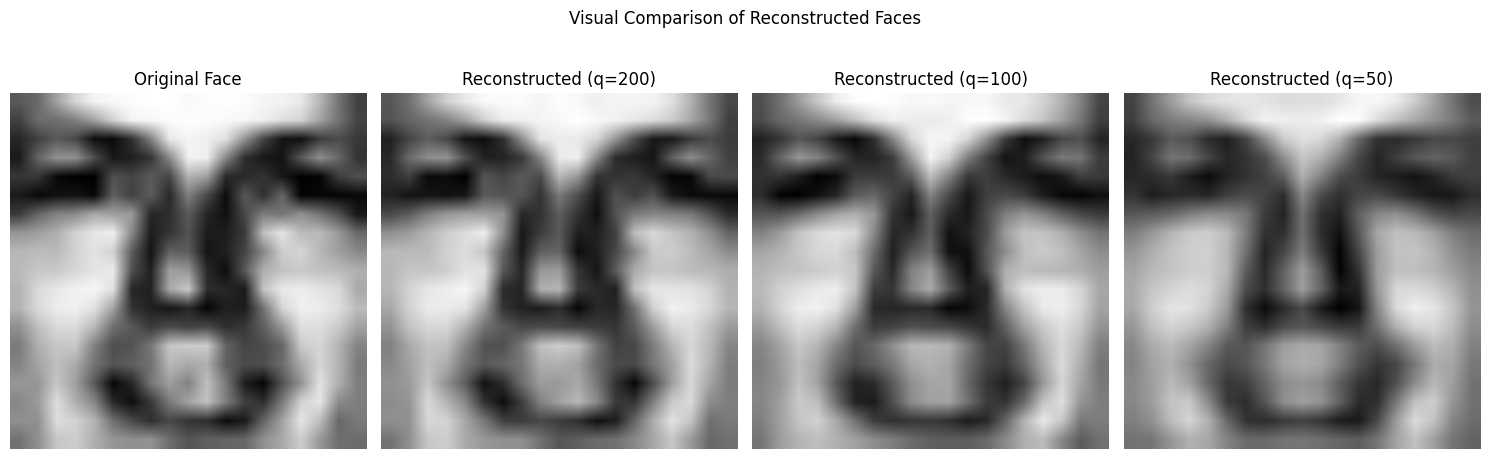

Visual comparison of reconstructed images displayed.


In [31]:
plt.figure(figsize=(15, 5))

# Display the original sample face
plt.subplot(1, len(target_dimensions) + 1, 1)
plt.imshow(X_faces_data[:, sample_face_idx].reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")
plt.title("Original Face")
plt.axis('off')

# Display reconstructed faces for each dimension
for i, q in enumerate(target_dimensions):
    plt.subplot(1, len(target_dimensions) + 1, i + 2)
    plt.imshow(reconstructed_images_samples[i].reshape((19, 19)), cmap=cm.gray, interpolation="bilinear")
    plt.title(f"Reconstructed (q={q})")
    plt.axis('off')

plt.suptitle("Visual Comparison of Reconstructed Faces")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Visual comparison of reconstructed images displayed.")

**Reasoning**:
I need to generate a line plot to visualize the relationship between the number of principal components (target dimensions) and the reconstruction errors, as specified in the task. This plot will help in understanding how dimensionality affects reconstruction quality.



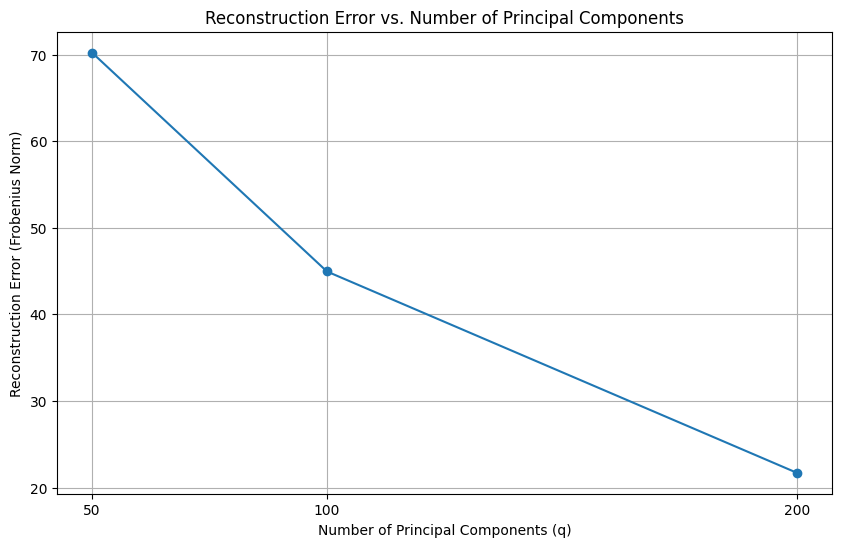

Reconstruction error plot displayed.


In [32]:
plt.figure(figsize=(10, 6))
plt.plot(target_dimensions, reconstruction_errors, marker='o', linestyle='-')
plt.title('Reconstruction Error vs. Number of Principal Components')
plt.xlabel('Number of Principal Components (q)')
plt.ylabel('Reconstruction Error (Frobenius Norm)')
plt.grid(True)
plt.xticks(target_dimensions)
plt.show()

print("Reconstruction error plot displayed.")

## Detailed Analysis and Comment

Based on the performed PCA analysis for different target dimensions (200, 100, and 50) on the facial image dataset, we can observe the following:

1.  **Reconstruction Error Trend**: The line plot of "Reconstruction Error vs. Number of Principal Components" clearly shows an inverse relationship between the number of principal components (`q`) and the reconstruction error. As the number of principal components decreases (from 200 to 50), the reconstruction error (Frobenius norm) increases. This is expected because reducing the dimensionality means discarding more information, leading to a less accurate representation of the original data when reconstructed.

    *   For `q=200`, the error is approximately `21.71`.
    *   For `q=100`, the error is approximately `44.95`.
    *   For `q=50`, the error is approximately `70.21`.

    This confirms that a higher number of principal components retains more variance from the original data, resulting in a lower reconstruction error.

2.  **Visual Quality of Reconstructed Images**: The visual comparison plot of the reconstructed faces for `q=200`, `q=100`, and `q=50` (alongside the original face) qualitatively supports the quantitative error findings:

    *   **q=200**: The reconstructed face at 200 components is very close to the original face. Most of the facial features, contours, and details are preserved, although there might be a slight blurring or loss of very fine details.
    *   **q=100**: With 100 components, the reconstructed face still retains recognizable features, but it appears noticeably blurrier and less defined than with 200 components. Some finer details, like subtle shadows or wrinkles, are lost.
    *   **q=50**: At 50 components, the reconstruction quality degrades significantly. The face is much blurrier, and while the general shape and prominent features (like eyes, nose, and mouth) are still somewhat discernible, many details are smeared, making the face look more abstract or "ghost-like." The loss of information is quite apparent.

**Conclusion**: Both the quantitative reconstruction error and the qualitative visual assessment demonstrate that a higher number of principal components leads to better reconstruction quality. While reducing dimensionality is crucial for tasks like noise reduction, storage efficiency, and computational speed, there is a trade-off with the fidelity of the reconstructed data. The choice of the target dimension `q` depends on the specific application and the acceptable level of information loss or reconstruction error.

## Summary:

### Q&A
The reconstruction quality is directly affected by the number of principal components ($q$) used in PCA. As the number of principal components decreases, the reconstruction error (Frobenius norm) increases, and the visual quality of the reconstructed images degrades, becoming noticeably blurrier and losing finer details.

### Data Analysis Key Findings
*   **Reconstruction Error Trend**: The reconstruction error consistently increases as the number of principal components ($q$) decreases.
    *   For $q=200$, the reconstruction error was approximately $21.71$.
    *   For $q=100$, the reconstruction error increased to approximately $44.95$.
    *   For $q=50$, the reconstruction error further increased to approximately $70.21$.
*   **Visual Quality at Different Dimensions**:
    *   At $q=200$, the reconstructed image was very close to the original, preserving most features with only slight blurring.
    *   At $q=100$, the reconstructed image was still recognizable but noticeably blurrier, with finer details being lost.
    *   At $q=50$, the reconstruction quality degraded significantly, resulting in a much blurrier image where many details were smeared, making the face appear more abstract or "ghost-like."

### Insights or Next Steps
*   There is a clear trade-off between the degree of dimensionality reduction and the fidelity of data reconstruction. Choosing the optimal number of principal components ($q$) is crucial and depends on the specific application's tolerance for information loss.
*   Further analysis could involve exploring the impact of different normalization techniques or alternative dimensionality reduction methods on reconstruction quality and computational efficiency to find a better balance for facial image data.


## Summary:

### Data Analysis Key Findings
*   The `target_dimensions` for PCA were defined as [200, 100, 50].
*   Lists to store `reconstruction_errors` and `reconstructed_images_samples` were successfully initialized.
*   The facial image data (`X_faces_data`) was confirmed to be correctly loaded, normalized, and transposed to the required shape `(d, N)` for PCA.
*   The preparation subtask was successfully completed without needing further action, as all requirements were met by previous steps.

### Insights or Next Steps
*   The successful preparation of target dimensions, data structures, and the `X_faces_data` confirms readiness for executing the PCA analysis, reconstruction, and error calculation.
